## Data exploration
I try to answer following questions:
* Are there missing values, duplicates, ...?
* Is the data balanced? 
* What is chance performance?

I will address these points below in separate subsections.

## Are there missing values, duplicates, ...
I start by loading a few packages that I would consider the standard analytics stack in python.

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

Now I read the data from a file. Here, I read all data to be able to see issues with the data. It is however important at this point to **not** make any actual model decisions, as this would likely result in bias.

In [2]:
data = pd.read_csv(
    './data/data_redacted.tsv',
    sep='\t'
)

In [3]:
data.describe()

,title,text,url,category
count,8646,8646,8646,8646
unique,8639,8646,8646,12
top,The 10 things in advertising you need to know ...,"In his new role, O’Brien will tutor a team, pr...",http://www.theguardian.com/uk-news/2016/apr/07...,fashion_beauty_lifestyle
freq,3,1,1,1398


We can see that there are in total 8646 articles in the data file, covering 12 different categories. It is important to make sure that no entry is duplicate. Otherwise, we might inflate our estimated generalization performance if the duplicate of an article from the training set ended up in the test set.
Although three articles have the same title, the corresponding text is different. Thus, there are no duplicate entries.

Another observation is that there are only 8639 unique titles in the dataset&mdash;7 less than there are articles. However, the most common title only occurs 3 times. Thus, there might be missing data or the data might otherwise be broken. A quick way to test that is to compare how many entries are left after removing all "missing" values with `.dropna`:

In [4]:
print(data.shape)
print(data.dropna().shape)

(8646, 4)
(8646, 4)


## Is the data balanced?

By balanced, we mean that all different categories make up an equal fraction of the data. Assessing if the data is balanced is important, because models trained on very imbalanced data might be biased. To assess if the data is balanced, we plot the distribution of category labels in the data:

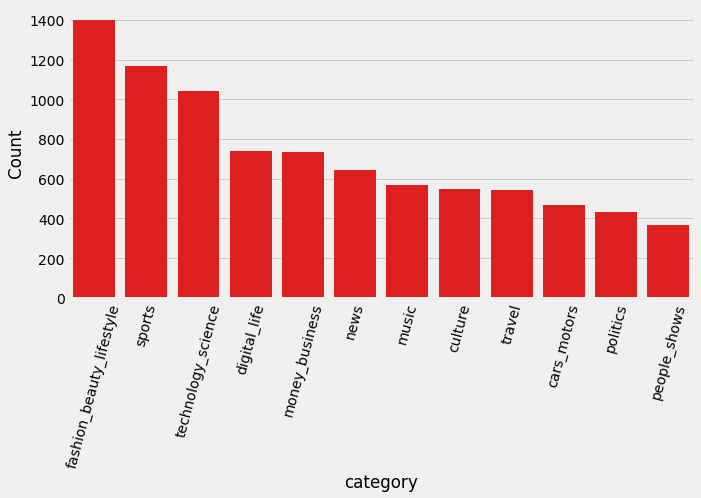

In [5]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.barplot(
    x='category',
    y='text',
    data = data.groupby('category').count().reset_index().sort_values('text', ascending=False),
    color='r'
)
plt.ylabel('Count')
plt.xticks(rotation=75)
plt.show()

We can see that the category "fashion_beauty_lifestyle" is present about 3.5x more often then the category "people_shows". Thus the data is in fact imbalanced. This is a rather moderate level of data imbalance. There are two ways we could account for this imbalance:
1. We could reweight the different classes during training, to train a model that does not have the class bias resulting from imbalance. Reweighting could be done by re-sampling the training data or (for some model classes) by weighting the corresponding error terms during training.
2. We could allow for a biased model, but establish a baseline of random performance that takes the imbalance into account. For example, in the extreme case, where we would 99% of data from one category "A" and 1% across all other categories, a classifier that always predicts "A" would be correct in 99% of the cases&mdash;without actually understanding anything about the data.
Given that the input data shows moderate imbalance, we prefer stategy 2. This assumes that similar category frequencies would be observed in "the wild" and that it this imbalance is not just an artifact of data collection. If this assumption turns out to be wrong we would need to reconsider this decision. 

## What is chance performance

As a next step, we want to establish chance performance (taking into account the imbalance in the category distribution). To be able to later compare this to our machine learning model, this step should not be done on all data, but rather on a subset that we set aside and use exclusively for model testing. In the accompanying python package, I implemented a `DataLoader` class, that ensures that everytime we load data as 'test', we get the same fixed subset of the original data (and similar for loading data as 'train').

In [6]:
from upday.data_loader import DataLoader

dloader = DataLoader()
train_data = dloader.load(subset='train')
test_data = dloader.load(subset='test')

When we discussed data imbalance, we already discussed a useful baseline model. This model picks the most common category (in the training data) and then always predicts that category. Importantly, we want to evaluate the performance of this model on the test data!

To "train" this model, we simply take the label distribution on the training data. For that, we simply re-create the plot that we had when we discussed imbalance, but this time we only look at the training data:

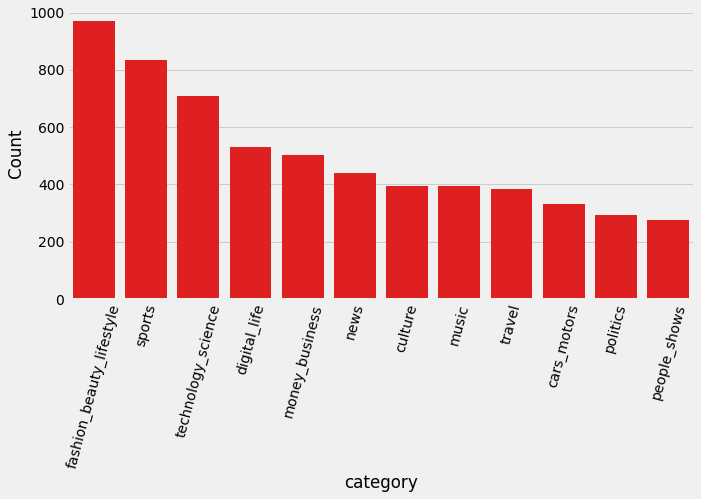

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.barplot(
    x='category',
    y='text',
    data=train_data.groupby('category').count().reset_index().sort_values('text', ascending=False),
    color='r'
)
plt.ylabel('Count')
plt.xticks(rotation=75)
plt.show()

Not surprisingly, "fashion_beauty_lifestyle" is still the most common category. Thus, the baseline model would always predict that category. How often would our baseline model be correct? To see that, we can calculate what fraction of the test dataset has the category "fashion_beauty_lifestyle":

In [8]:
baseline_accuracy = (test_data['category'] == 'fashion_beauty_lifestyle').mean()

print(f'Baseline accuracy: {100*baseline_accuracy:.4f}%')

Baseline accuracy: 16.5060%


Thus our baseline model is correct about 16.5% of the time. Note that this is considerably more than the 8.33% that a random model on balanced data would get.

# Results

The actual machine learning code is implemented in the accompanying python package called `upday`. This way, we can import the code later in a production setting. Here, we will discuss the model and just call high-level functions from that package.

## Model structure

Models that deal with text usually face two challenges:
1. While mathematical models are expressed in terms of algebraic entities like numbers and vectors, words are not. Typically, every word is different and it is a-priori unclear what we would for example mean by "dog" + "sports".
2. Mathematical models typically deal with fixed length vectors, but text varies in length without becoming qualitatively different.

It is common to address the first problem through a technique called "embeddings": Every word is associated with a (dense) vector in some high dimensional vector space. Importantly, the identity of these vectors is learned from data. There are different strategies for doing so. The most well known one is called word2vec, alternatively one could attempt to train these word embeddings end-2-end to serve the task at hand.

There is a range of options to combine the vector representations of individual words into a vector representation of the entire sentence. The simplest approach would be to simply average all the word vectors in a sentence. More advanced methods typically rely on attention mechanisms, that model how important which word in a sentence is for solving the current prediction.

In the interest of time, I decided to use a pretrained sentence embedding: This model learns 50-dimensional word embeddings and then aggregates vector representations of the individual words by taking the sum and normalizing by the 2-norm of the resulting vector (square root of sum of squares). This model is available through tensorflow_hub at this url: https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1
The pretrained sentence embeddings model has been trained on the google news dataset (7B sentences).

I use this pretrained embedding to embed both, the title and the text of each article and then train a logistic regression with L2 penalty on the resulting feature matrix. One could use different models for this step, but logistic regression is fairly simple and usually a good starting point. The dataset is a little small to actually train a full neural network end-to-end. The weight of the L2 penalty was determined using 10-fold cross validation.

As mentioned above, the training is covered in the `upday.ml` package:


In [9]:
from upday import ml

trained_model = ml.train(train_data)

/home/tara/Code/UpDay/.venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


The returned `trained_model` is a `namedtuple` with separate fields for the embeddings and the classifier. We will now proceed to the model evaluation.

## Metrics and model evaluation

To evaluate the models, we will start by simply evaluating the model's accuracy on the test data set. We already have this for the baseline model (reminder: the baseline model achieved 16.5060%) the main question is if our new model is better than the baseline model. We again rely on our `upday.ml` package to guarantee that we run the exact same code as we would when calling the evaluation as a script.

In [10]:
trained_accuracy = ml.evaluate(test_data, trained_model)

print(f'Trained model test accuracy: {100*trained_accuracy:.4f}%')

Trained model test accuracy: 82.6070%


Good news: Our trained model performs *much* better than the baseline model. In fact the difference in accuracy is sufficiently large that it is extremely unlikely that this difference would just result from a lucky choice of evaluation data.

Another useful metric 

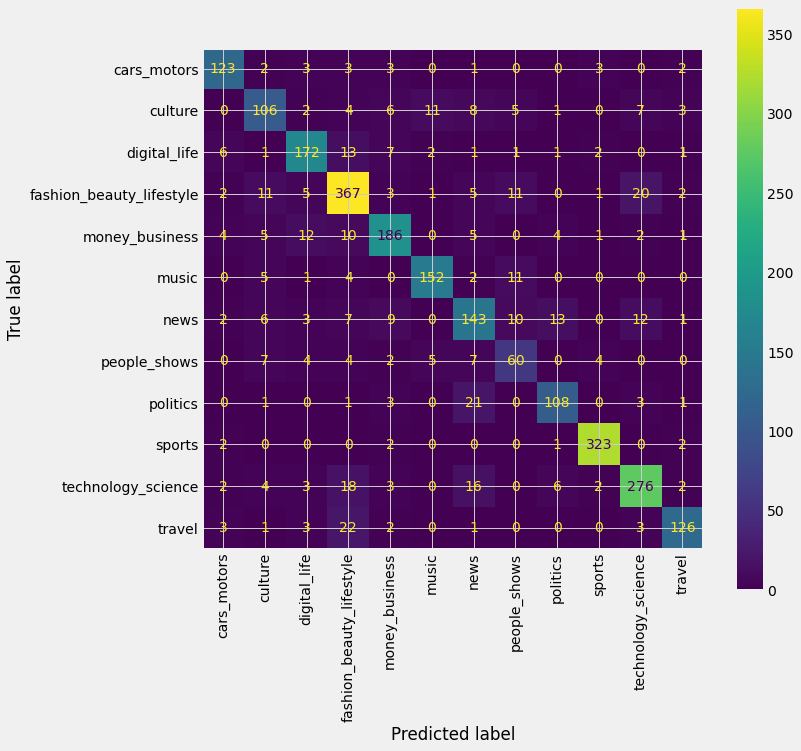

In [11]:
from sklearn.metrics import plot_confusion_matrix

predictions = ml.predict(test_data['title'].values.tolist(), test_data['text'].values.tolist(), trained_model)

# sklearn's plot_confusion_matrix needs a classifier, but our classifier doesn't do the feature calculation
# This fake class forwards all requests to the trained_model.classifier instance except for the call to predict.
# This allows us to pass the pre-computed predictions into the function.
class FakeClassifier:
    def __getattr__(self, a):
        return getattr(trained_model.classifier, a)
    
    def predict(self, X):
        return predictions

fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(FakeClassifier(), None, test_data['category'].values, xticks_rotation='vertical', ax=ax)

Looking at the confusion matrix we can observe that most of the errors of the model come from the following categories:
- 22 "travel" articles are categorized as "fashion_beauty_lifestyle". Not horribly wrong: For many people traveling is a lifestyle and other people like to show their latest fashion items at exotic destinations.
- 21 "politics" articles were categorized as "news". Honestly, I would probably do the same mistake.
- 20 "fashion_beauty_lifestyle" articles were categorized as "technology_science". Initially, there seems to be less overlap between these categories. However, I could imagine that articles about new cell phones or apple headphones could well be an area of overlap between those two categories. It would be worthwhile to look at one or two of these misclassified articles to confirm that suspicion.

# Productionalization

On Monday, I downloaded the assignment and started working on it on Friday. When I checked something on the github page today, I found out that the task requirements had been changed and that I was now supposed to also comment on productionalization strategies for this model. Given that I did most of the work yesterday, I will only briefly sketch this part.

1. Unit tests: I know how to write unit tests and illustrated that by writing a total of 3 unit tests. The first one validates that repeatedly loading data from that data loader results in the exact same training set. The other two validate that the sentence embedding class returns the correct embedded shape for individual sentences and for multiple sentences. Although this doesn't fully cover all functionality in the `upday` package, it serves to illustrate the point.
2. The `DataLoader` and `ModelSaver` in `upday.data_loader` provide abstractions for data loading and model storage. I am not familiar with the data base environment in which the model would run. However, by adapting these two classes the evaluate, train, predict scripts in the `scripts/` can be integrated into data pipeline systems such as Airflow. For example, the `DataLoader` could load data through a SQL query instead of loading them from the hard drive.

## Outlook: Insight from the URL

Our trained model does not use the URL of the article. However, for some articles, the category seem to be a part of Url. Unfortunately, the position of the category whithin the Url is different. 
One way of using this valuable information is to build a reference table which indicates the position of the category in the url given the name of agency or 0 if the agency doesn't provide this information. We could use the provided category as a categorical feature.

In [12]:
data[['category', 'url']].head(10)

,category,url
0,technology_science,http://discovermagazine.com/2014/nov/13-y-not
1,digital_life,http://www.ibtimes.co.uk/destiny-bungie-introd...
2,sports,http://www.thecheckeredflag.co.uk/2015/12/daru...
3,technology_science,http://www.sciencedaily.com/releases/2016/02/1...
4,fashion_beauty_lifestyle,http://www.popsugar.com/beauty/How-Use-Brow-Ge...
5,fashion_beauty_lifestyle,https://childdevelopmentinfo.com/ages-stages/t...
6,money_business,http://www.newsworks.org.uk/News-and-Opinion/a...
7,technology_science,http://www.independent.co.uk/life-style/health...
8,politics,http://www.independent.co.uk/news/education/ed...
9,politics,http://www.birminghammail.co.uk/news/news-opin...


In [13]:
data['url'].str.split('/', expand=True)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,http:,,discovermagazine.com,2014,nov,13-y-not,None,None,None,None,None,None,None,None
1,http:,,www.ibtimes.co.uk,destiny-bungie-introduce-ammo-pack-micro-trans...,None,None,None,None,None,None,None,None,None,None
2,http:,,www.thecheckeredflag.co.uk,2015,12,daruvala-to-race-for-josef-kaufmann-racing-in-...,,None,None,None,None,None,None,None
3,http:,,www.sciencedaily.com,releases,2016,02,160208135436.htm,None,None,None,None,None,None,None
4,http:,,www.popsugar.com,beauty,How-Use-Brow-Gel-38516588,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8641,https:,,www.theguardian.com,lifeandstyle,2016,jul,11,should-groom-pubic-hair-shaving-trimming,None,None,None,None,None,None
8642,http:,,www.popsugar.com,celebrity,Justin-Timberlake-Jessica-Biel-Out-LA-Dec-2015...,None,None,None,None,None,None,None,None,None
8643,http:,,www.theguardian.com,lifeandstyle,2015,sep,25,two-cats-kitchen-birmingham-restaurant-review-...,None,None,None,None,None,None
8644,http:,,www.inc.com,derek-flanzraich,5-tips-from-a-health-expert-to-finally-get-hea...,None,None,None,None,None,None,None,None,None
